<a href="https://colab.research.google.com/github/alim98/MPI/blob/main/temp/Final_DL_VGG_MPItemp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Essential downloads

In [1]:
!wget -O downloaded_file.zip "https://drive.usercontent.google.com/download?id=1iHPBdBOPEagvPTHZmrN__LD49emXwReY&export=download&authuser=0&confirm=t&uuid=631d60dd-569c-4bb1-a9e8-d681f0ed3d43&at=APvzH3r4me8x_LwP3n8O7lgPo8oK%3A1733988188000"
!wget -O vesicle_cloud__syn_interface__mitochondria_annotation.zip "https://drive.usercontent.google.com/download?id=1qRibZL3kr7MQJQRgDFRquHMQlIGCN4XP&export=download&authuser=0&confirm=t&uuid=631d60dd-569c-4bb1-a9e8-d681f0ed3d43&at=APvzH3r4me8x_LwP3n8O7lgPo8oK%3A1733988188000"

!unzip -q downloaded_file.zip
!unzip -q vesicle_cloud__syn_interface__mitochondria_annotation.zip

!pip install transformers scikit-learn matplotlib seaborn torch torchvision umap-learn git+https://github.com/funkelab/funlib.learn.torch.git
!pip install openpyxl


--2025-01-31 08:04:41--  https://drive.usercontent.google.com/download?id=1iHPBdBOPEagvPTHZmrN__LD49emXwReY&export=download&authuser=0&confirm=t&uuid=631d60dd-569c-4bb1-a9e8-d681f0ed3d43&at=APvzH3r4me8x_LwP3n8O7lgPo8oK%3A1733988188000
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 64.233.189.132, 2404:6800:4008:c07::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|64.233.189.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1264688649 (1.2G) [application/octet-stream]
Saving to: ‘downloaded_file.zip’

downloaded_file.zip 100%[===================>]   1.18G  54.2MB/s    in 21s     

2025-01-31 08:05:05 (56.1 MB/s) - ‘downloaded_file.zip’ saved [1264688649/1264688649]

--2025-01-31 08:05:05--  https://drive.usercontent.google.com/download?id=1qRibZL3kr7MQJQRgDFRquHMQlIGCN4XP&export=download&authuser=0&confirm=t&uuid=631d60dd-569c-4bb1-a9e8-d681f0ed3d43&at=APvzH3r4me8x_LwP3n8O7lgPo8oK%3A1733988188000
Resolvin

# Version1 , black overlay on unmasked sections of image

In [ ]:
# Alpha Blending (Unmasked Areas):
# Instead of blending the raw image with the mask and using a color, for unmasked regions we now blend the raw_rgb image with a black overlay. This keeps the masked regions unchanged but gives unmasked regions a 50% black overlay.
# Unmasked Regions:
# The raw image is modified so that the unmasked areas blend with 50% black (0.5 * raw_rgb + 0.5 * black_overlay), where black_overlay is a black (zeroed) array of the same shape as the raw_rgb.
import os
import glob
import io
import argparse
import multiprocessing
from typing import List, Tuple

import numpy as np
import pandas as pd
import imageio.v3 as iio
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms
class Synapse3DProcessor:
    def __init__(self, size=(80, 80), mean=(0.485,),  # Use a single channel for grayscale
                 std=(0.229,)):
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(size),
            transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std),
        ])

    def __call__(self, frames, return_tensors=None):
        processed_frames = [self.transform(frame) for frame in frames]
        pixel_values = torch.stack(processed_frames)
        if return_tensors == "pt":
            return {"pixel_values": pixel_values}
        else:
            return pixel_values


def load_volumes(bbox_name: str, raw_base_dir: str, seg_base_dir: str, add_mask_base_dir: str) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    raw_dir = os.path.join(raw_base_dir, bbox_name)
    seg_dir = os.path.join(seg_base_dir, bbox_name)

    if bbox_name.startswith("bbox"):
        bbox_num = bbox_name.replace("bbox", "")
        add_mask_dir = os.path.join(add_mask_base_dir, f"bbox_{bbox_num}")
    else:
        add_mask_dir = os.path.join(add_mask_base_dir, bbox_name)

    raw_tif_files = sorted(glob.glob(os.path.join(raw_dir, 'slice_*.tif')))
    seg_tif_files = sorted(glob.glob(os.path.join(seg_dir, 'slice_*.tif')))
    add_mask_tif_files = sorted(glob.glob(os.path.join(add_mask_dir, 'slice_*.tif')))

    if not (len(raw_tif_files) == len(seg_tif_files) == len(add_mask_tif_files)):
        return None, None, None

    try:
        raw_vol = np.stack([iio.imread(f) for f in raw_tif_files], axis=0)
        seg_vol = np.stack([iio.imread(f).astype(np.uint32) for f in seg_tif_files], axis=0)
        add_mask_vol = np.stack([iio.imread(f).astype(np.uint32) for f in add_mask_tif_files], axis=0)
        return raw_vol, seg_vol, add_mask_vol
    except Exception as e:
        return None, None, None


def create_segmented_cube(
    raw_vol: np.ndarray,
    seg_vol: np.ndarray,
    add_mask_vol: np.ndarray,
    central_coord: Tuple[int, int, int],
    side1_coord: Tuple[int, int, int],
    side2_coord: Tuple[int, int, int],
    segmentation_type: int,
    subvolume_size: int = 80,
    alpha: float = 0.3,
    input_mask: bool = False  # New parameter
) -> np.ndarray:
    def create_segment_masks(segmentation_volume, s1_coord, s2_coord):
        x1, y1, z1 = s1_coord
        x2, y2, z2 = s2_coord
        seg_id_1 = segmentation_volume[z1, y1, x1]
        seg_id_2 = segmentation_volume[z2, y2, x2]

        mask_1 = (segmentation_volume == seg_id_1) if seg_id_1 != 0 else np.zeros_like(segmentation_volume, dtype=bool)
        mask_2 = (segmentation_volume == seg_id_2) if seg_id_2 != 0 else np.zeros_like(segmentation_volume, dtype=bool)
        return mask_1, mask_2

    mask_1_full, mask_2_full = create_segment_masks(seg_vol, side1_coord, side2_coord)
    mask_3_full = (add_mask_vol > 0)

    # Combine all the masks using OR
    combined_mask_full = np.logical_or(mask_1_full, np.logical_or(mask_2_full, mask_3_full))

    half_size = subvolume_size // 2
    cx, cy, cz = central_coord
    x_start, x_end = max(cx - half_size, 0), min(cx + half_size, raw_vol.shape[2])
    y_start, y_end = max(cy - half_size, 0), min(cy + half_size, raw_vol.shape[1])
    z_start, z_end = max(cz - half_size, 0), min(cz + half_size, raw_vol.shape[0])

    sub_raw = raw_vol[z_start:z_end, y_start:y_end, x_start:x_end]
    sub_combined_mask = combined_mask_full[z_start:z_end, y_start:y_end, x_start:x_end]

    pad_z = subvolume_size - sub_raw.shape[0]
    pad_y = subvolume_size - sub_raw.shape[1]
    pad_x = subvolume_size - sub_raw.shape[2]

    if pad_z > 0 or pad_y > 0 or pad_x > 0:
        sub_raw = np.pad(sub_raw, ((0, pad_z), (0, pad_y), (0, pad_x)), mode='constant', constant_values=0)
        sub_combined_mask = np.pad(sub_combined_mask, ((0, pad_z), (0, pad_y), (0, pad_x)), mode='constant', constant_values=False)

    sub_raw = sub_raw[:subvolume_size, :subvolume_size, :subvolume_size]
    sub_combined_mask = sub_combined_mask[:subvolume_size, :subvolume_size, :subvolume_size]

    overlaid_cube = np.zeros((subvolume_size, subvolume_size, 3, subvolume_size), dtype=np.uint8)

    alpha_black = 0.7  # Adjust this value to control the darkness of unmasked regions

    for z in range(subvolume_size):
        raw_slice = sub_raw[z].astype(np.float32)
        mn, mx = raw_slice.min(), raw_slice.max()
        if mx > mn:
            raw_slice = (raw_slice - mn) / (mx - mn)
        else:
            raw_slice = raw_slice - mn

        # Apply blending based on the combined mask
        raw_rgb = np.stack([raw_slice] * 3, axis=-1)

        # Create mask factor
        mask_factor = sub_combined_mask[z, :, :, np.newaxis]

        # Blend: mask regions remain original, unmasked are scaled by (1 - alpha_black)
        raw_rgb = raw_rgb * (mask_factor + (1 - mask_factor) * (1 - alpha_black))

        overlaid_image = (np.clip(raw_rgb, 0, 1) * 255).astype(np.uint8)

        overlaid_cube[:, :, :, z] = overlaid_image

    return overlaid_cube


class SynapseDataset(Dataset):
    def __init__(self, vol_data_dict: dict, synapse_df: pd.DataFrame, processor,
                 segmentation_type: int, subvol_size: int = 80, num_frames: int = 16,
                 alpha: float = 0.3, input_mask: bool = False):  # Added input_mask
        self.vol_data_dict = vol_data_dict
        self.synapse_df = synapse_df.reset_index(drop=True)
        self.processor = processor
        self.segmentation_type = segmentation_type
        self.subvol_size = subvol_size
        self.num_frames = num_frames
        self.alpha = alpha
        self.input_mask = input_mask  # Store input_mask flag

    def __len__(self):
        return len(self.synapse_df)

    def __getitem__(self, idx):
        syn_info = self.synapse_df.iloc[idx]
        bbox_name = syn_info['bbox_name']
        raw_vol, seg_vol, add_mask_vol = self.vol_data_dict.get(bbox_name, (None, None, None))

        if raw_vol is None:
            return torch.zeros((self.num_frames, 3, self.subvol_size, self.subvol_size), dtype=torch.float32), syn_info, bbox_name

        central_coord = (int(syn_info['central_coord_1']), int(syn_info['central_coord_2']), int(syn_info['central_coord_3']))
        side1_coord = (int(syn_info['side_1_coord_1']), int(syn_info['side_1_coord_2']), int(syn_info['side_1_coord_3']))
        side2_coord = (int(syn_info['side_2_coord_1']), int(syn_info['side_2_coord_2']), int(syn_info['side_2_coord_3']))

        overlaid_cube = create_segmented_cube(
            raw_vol=raw_vol,
            seg_vol=seg_vol,
            add_mask_vol=add_mask_vol,
            central_coord=central_coord,
            side1_coord=side1_coord,
            side2_coord=side2_coord,
            segmentation_type=self.segmentation_type,
            subvolume_size=self.subvol_size,
            alpha=self.alpha,
            input_mask=self.input_mask  # Pass the flag
        )

        frames = [overlaid_cube[..., z] for z in range(overlaid_cube.shape[3])]
        if len(frames) < self.num_frames:
            frames += [frames[-1]] * (self.num_frames - len(frames))
        elif len(frames) > self.num_frames:
            indices = np.linspace(0, len(frames)-1, self.num_frames, dtype=int)
            frames = [frames[i] for i in indices]

        inputs = self.processor(frames, return_tensors="pt")
        return inputs["pixel_values"].squeeze(0).float(), syn_info, bbox_name
# ,'bbox2','bbox3','bbox4','bbox5','bbox6',
def parse_args():
    parser = argparse.ArgumentParser(description="VideoMAE Pre-training Script with Segmented Videos and Additional Masks")
    parser.add_argument('--raw_base_dir', type=str, default='raw')
    parser.add_argument('--seg_base_dir', type=str, default='seg')
    parser.add_argument('--add_mask_base_dir', type=str, default='')
    parser.add_argument('--bbox_name', type=str, default=['bbox1' ], nargs='+')
    parser.add_argument('--excel_file', type=str, default='')
    parser.add_argument('--csv_output_dir', type=str, default='csv_outputs')
    parser.add_argument('--checkpoint_dir', type=str, default='checkpoints')
    parser.add_argument('--log_dir', type=str, default='logs')
    parser.add_argument('--size', type=tuple, default=(80,80))
    parser.add_argument('--batch_size', type=int, default=2)
    parser.add_argument('--num_epochs', type=int, default=5)
    parser.add_argument('--learning_rate', type=float, default=1e-4)
    parser.add_argument('--weight_decay', type=float, default=1e-2)
    parser.add_argument('--subvol_size', type=int, default=80)
    parser.add_argument('--num_frames', type=int, default=80)
    parser.add_argument('--mask_ratio', type=float, default=0.75)
    parser.add_argument('--patience', type=int, default=3)
    parser.add_argument('--resume_checkpoint', type=str, default=None)
    parser.add_argument('--save_gifs_dir', type=str, default='gifs')
    parser.add_argument('--num_gifs', type=int, default=10)
    parser.add_argument('--alpha', type=float, default=0.9)
    parser.add_argument('--segmentation_type', type=int, default=5, choices=range(0, 6))
    parser.add_argument('--input_mask', action='store_true', # Added argument
                       help='Mask input image using segmentation_type regions')
    args, _ = parser.parse_known_args()

    return args

def main(args):
    processor = Synapse3DProcessor(size=(80, 80))
    vol_data_dict = {}

    for bbox_name in args.bbox_name:
        raw_vol, seg_vol, add_mask_vol = load_volumes(
            bbox_name=bbox_name,
            raw_base_dir=args.raw_base_dir,
            seg_base_dir=args.seg_base_dir,
            add_mask_base_dir=args.add_mask_base_dir
        )
        if raw_vol is not None:
            vol_data_dict[bbox_name] = (raw_vol, seg_vol, add_mask_vol)

    synapse_dfs = []
    for bbox_name in args.bbox_name:
        excel_path = os.path.join(args.excel_file, f"{bbox_name}.xlsx")
        if os.path.exists(excel_path):
            df = pd.read_excel(excel_path)
            df['bbox_name'] = bbox_name
            synapse_dfs.append(df)

    syn_df = pd.concat(synapse_dfs, ignore_index=True)
    dataset = SynapseDataset(
        vol_data_dict=vol_data_dict,
        synapse_df=syn_df,
        processor=processor,
        segmentation_type=args.segmentation_type,
        subvol_size=args.subvol_size,
        num_frames=args.num_frames,
        alpha=args.alpha,
        input_mask=args.input_mask  # Pass the flag
    )

    cubes = []
    syn_info_list = []
    for idx in range(len(dataset)):
        pixel_values, syn_info, _ = dataset[idx]
        cubes.append(pixel_values)
        syn_info_list.append(syn_info)

    print(f"Processed {len(cubes)} cubes successfully.")
    return cubes, pd.DataFrame(syn_info_list)

# if __name__ == "__main__":
args = parse_args()

args.input_mask=False
cubes, sys_inf = main(args)
print(f"Final output: {len(cubes)} cubes")

# Extract the data tensor (cube) from the tuple returned by dataset[0]
cube = cubes[0]

mean = torch.tensor([0.485]).view(1, 1, 1, 1)
std = torch.tensor([0.229]).view(1, 1, 1, 1)

denormalized_cube = cube * std + mean
denormalized_cube = torch.clamp(denormalized_cube, 0, 1)

# Convert to RGB if needed
frames = denormalized_cube.squeeze(1).numpy()  # Remove channel dimension
frames = (frames * 255).astype(np.uint8)

# Stack to create RGB
frames = np.stack([frames, frames, frames], axis=-1)

Gif_Name = f"VGG_Gif_segmentation_type_{args.segmentation_type}_input_mask_{args.input_mask}"
# Gif_Name = f"VGG_Gif_segmentation_type_{args.segmentation_type}_input_mask_True"
output_gif_path = os.path.join("", f"{Gif_Name}.gif")
# Save the frames as a gif using imageio
imageio.mimsave(output_gif_path, frames, fps=10)


Processed 58 cubes successfully.
Final output: 58 cubes


# Version 2 - avg color overlay

In [ ]:
# Alpha Blending (Unmasked Areas):
# Instead of blending the raw image with the mask and using a color, for unmasked regions we now blend the raw_rgb image with a black overlay. This keeps the masked regions unchanged but gives unmasked regions a 50% black overlay.
# Unmasked Regions:
# The raw image is modified so that the unmasked areas blend with 50% black (0.5 * raw_rgb + 0.5 * black_overlay), where black_overlay is a black (zeroed) array of the same shape as the raw_rgb.
import os
import glob
import io
import argparse
import multiprocessing
from typing import List, Tuple
import imageio
import numpy as np
import pandas as pd
import imageio.v3 as iio
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms
class Synapse3DProcessor:
    def __init__(self, size=(80, 80), mean=(0.485,),  # Use a single channel for grayscale
                 std=(0.229,)):
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(size),
            transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std),
        ])

    def __call__(self, frames, return_tensors=None):
        processed_frames = [self.transform(frame) for frame in frames]
        pixel_values = torch.stack(processed_frames)
        if return_tensors == "pt":
            return {"pixel_values": pixel_values}
        else:
            return pixel_values


def load_volumes(bbox_name: str, raw_base_dir: str, seg_base_dir: str, add_mask_base_dir: str) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    raw_dir = os.path.join(raw_base_dir, bbox_name)
    seg_dir = os.path.join(seg_base_dir, bbox_name)

    if bbox_name.startswith("bbox"):
        bbox_num = bbox_name.replace("bbox", "")
        add_mask_dir = os.path.join(add_mask_base_dir, f"bbox_{bbox_num}")
    else:
        add_mask_dir = os.path.join(add_mask_base_dir, bbox_name)

    raw_tif_files = sorted(glob.glob(os.path.join(raw_dir, 'slice_*.tif')))
    seg_tif_files = sorted(glob.glob(os.path.join(seg_dir, 'slice_*.tif')))
    add_mask_tif_files = sorted(glob.glob(os.path.join(add_mask_dir, 'slice_*.tif')))

    if not (len(raw_tif_files) == len(seg_tif_files) == len(add_mask_tif_files)):
        return None, None, None

    try:
        raw_vol = np.stack([iio.imread(f) for f in raw_tif_files], axis=0)
        seg_vol = np.stack([iio.imread(f).astype(np.uint32) for f in seg_tif_files], axis=0)
        add_mask_vol = np.stack([iio.imread(f).astype(np.uint32) for f in add_mask_tif_files], axis=0)
        return raw_vol, seg_vol, add_mask_vol
    except Exception as e:
        return None, None, None

def create_segmented_cube(
    raw_vol: np.ndarray,
    seg_vol: np.ndarray,
    add_mask_vol: np.ndarray,
    central_coord: Tuple[int, int, int],
    side1_coord: Tuple[int, int, int],
    side2_coord: Tuple[int, int, int],
    segmentation_type: int,
    subvolume_size: int = 80,
    alpha: float = 0.3,
    input_mask: bool = False,
) -> np.ndarray:
    def create_segment_masks(segmentation_volume, s1_coord, s2_coord):
        x1, y1, z1 = s1_coord
        x2, y2, z2 = s2_coord
        seg_id_1 = segmentation_volume[z1, y1, x1]
        seg_id_2 = segmentation_volume[z2, y2, x2]

        mask_1 = (segmentation_volume == seg_id_1) if seg_id_1 != 0 else np.zeros_like(segmentation_volume, dtype=bool)
        mask_2 = (segmentation_volume == seg_id_2) if seg_id_2 != 0 else np.zeros_like(segmentation_volume, dtype=bool)
        return mask_1, mask_2

    mask_1_full, mask_2_full = create_segment_masks(seg_vol, side1_coord, side2_coord)
    mask_3_full = (add_mask_vol > 0)

    combined_mask_full = np.logical_or(mask_1_full, np.logical_or(mask_2_full, mask_3_full))

    half_size = subvolume_size // 2
    cx, cy, cz = central_coord
    x_start, x_end = max(cx - half_size, 0), min(cx + half_size, raw_vol.shape[2])
    y_start, y_end = max(cy - half_size, 0), min(cy + half_size, raw_vol.shape[1])
    z_start, z_end = max(cz - half_size, 0), min(cz + half_size, raw_vol.shape[0])

    sub_raw = raw_vol[z_start:z_end, y_start:y_end, x_start:x_end]
    sub_combined_mask = combined_mask_full[z_start:z_end, y_start:y_end, x_start:x_end]

    pad_z = subvolume_size - sub_raw.shape[0]
    pad_y = subvolume_size - sub_raw.shape[1]
    pad_x = subvolume_size - sub_raw.shape[2]

    if pad_z > 0 or pad_y > 0 or pad_x > 0:
        sub_raw = np.pad(sub_raw, ((0, pad_z), (0, pad_y), (0, pad_x)), mode='constant', constant_values=0)
        sub_combined_mask = np.pad(sub_combined_mask, ((0, pad_z), (0, pad_y), (0, pad_x)), mode='constant', constant_values=False)

    sub_raw = sub_raw[:subvolume_size, :subvolume_size, :subvolume_size]
    sub_combined_mask = sub_combined_mask[:subvolume_size, :subvolume_size, :subvolume_size]

    overlaid_cube = np.zeros((subvolume_size, subvolume_size, 3, subvolume_size), dtype=np.uint8)

    for z in range(subvolume_size):
        raw_slice = sub_raw[z].astype(np.float32)
        mn, mx = raw_slice.min(), raw_slice.max()
        if mx > mn:
            raw_slice = (raw_slice - mn) / (mx - mn)
        else:
            raw_slice = raw_slice - mn

        raw_rgb = np.stack([raw_slice] * 3, axis=-1)

        # Create 2D mask for unmasked regions
        mask_factor = sub_combined_mask[z]  # This is now 2D

        # Calculate average color of unmasked regions
        unmasked_pixels = raw_slice[~mask_factor]  # Get unmasked pixel values
        if len(unmasked_pixels) > 0:
            avg_color = unmasked_pixels.mean()
        else:
            avg_color = 0  # In case there are no unmasked pixels

        # Blend: apply transparency control (alpha_black)
        raw_rgb = raw_rgb * mask_factor[:, :, np.newaxis] + (1 - mask_factor[:, :, np.newaxis]) * (alpha * avg_color + (1 - alpha) * raw_rgb)

        overlaid_image = (np.clip(raw_rgb, 0, 1) * 255).astype(np.uint8)

        overlaid_cube[:, :, :, z] = overlaid_image

    return overlaid_cube


class SynapseDataset(Dataset):
    def __init__(self, vol_data_dict: dict, synapse_df: pd.DataFrame, processor,
                 segmentation_type: int, subvol_size: int = 80, num_frames: int = 16,
                 alpha: float = 0.3, input_mask: bool = False):  # Added input_mask
        self.vol_data_dict = vol_data_dict
        self.synapse_df = synapse_df.reset_index(drop=True)
        self.processor = processor
        self.segmentation_type = segmentation_type
        self.subvol_size = subvol_size
        self.num_frames = num_frames
        self.alpha = alpha
        self.input_mask = input_mask  # Store input_mask flag

    def __len__(self):
        return len(self.synapse_df)

    def __getitem__(self, idx):
        syn_info = self.synapse_df.iloc[idx]
        bbox_name = syn_info['bbox_name']
        raw_vol, seg_vol, add_mask_vol = self.vol_data_dict.get(bbox_name, (None, None, None))

        if raw_vol is None:
            return torch.zeros((self.num_frames, 3, self.subvol_size, self.subvol_size), dtype=torch.float32), syn_info, bbox_name

        central_coord = (int(syn_info['central_coord_1']), int(syn_info['central_coord_2']), int(syn_info['central_coord_3']))
        side1_coord = (int(syn_info['side_1_coord_1']), int(syn_info['side_1_coord_2']), int(syn_info['side_1_coord_3']))
        side2_coord = (int(syn_info['side_2_coord_1']), int(syn_info['side_2_coord_2']), int(syn_info['side_2_coord_3']))

        overlaid_cube = create_segmented_cube(
            raw_vol=raw_vol,
            seg_vol=seg_vol,
            add_mask_vol=add_mask_vol,
            central_coord=central_coord,
            side1_coord=side1_coord,
            side2_coord=side2_coord,
            segmentation_type=self.segmentation_type,
            subvolume_size=self.subvol_size,
            alpha=self.alpha,
            input_mask=self.input_mask  # Pass the flag
        )

        frames = [overlaid_cube[..., z] for z in range(overlaid_cube.shape[3])]
        if len(frames) < self.num_frames:
            frames += [frames[-1]] * (self.num_frames - len(frames))
        elif len(frames) > self.num_frames:
            indices = np.linspace(0, len(frames)-1, self.num_frames, dtype=int)
            frames = [frames[i] for i in indices]

        inputs = self.processor(frames, return_tensors="pt")
        return inputs["pixel_values"].squeeze(0).float(), syn_info, bbox_name
# ,'bbox2','bbox3','bbox4','bbox5','bbox6',
def parse_args():
    parser = argparse.ArgumentParser(description="VideoMAE Pre-training Script with Segmented Videos and Additional Masks")
    parser.add_argument('--raw_base_dir', type=str, default='raw')
    parser.add_argument('--seg_base_dir', type=str, default='seg')
    parser.add_argument('--add_mask_base_dir', type=str, default='')
    parser.add_argument('--bbox_name', type=str, default=['bbox1' ], nargs='+')
    parser.add_argument('--excel_file', type=str, default='')
    parser.add_argument('--csv_output_dir', type=str, default='csv_outputs')
    parser.add_argument('--checkpoint_dir', type=str, default='checkpoints')
    parser.add_argument('--log_dir', type=str, default='logs')
    parser.add_argument('--size', type=tuple, default=(80,80))
    parser.add_argument('--batch_size', type=int, default=2)
    parser.add_argument('--num_epochs', type=int, default=5)
    parser.add_argument('--learning_rate', type=float, default=1e-4)
    parser.add_argument('--weight_decay', type=float, default=1e-2)
    parser.add_argument('--subvol_size', type=int, default=80)
    parser.add_argument('--num_frames', type=int, default=80)
    parser.add_argument('--mask_ratio', type=float, default=0.75)
    parser.add_argument('--patience', type=int, default=3)
    parser.add_argument('--resume_checkpoint', type=str, default=None)
    parser.add_argument('--save_gifs_dir', type=str, default='gifs')
    parser.add_argument('--num_gifs', type=int, default=10)
    parser.add_argument('--alpha', type=float, default=0.9)
    parser.add_argument('--segmentation_type', type=int, default=5, choices=range(0, 6))
    parser.add_argument('--input_mask', action='store_true', # Added argument
                       help='Mask input image using segmentation_type regions')
    args, _ = parser.parse_known_args()

    return args

def main(args):
    processor = Synapse3DProcessor(size=(80, 80))
    vol_data_dict = {}

    for bbox_name in args.bbox_name:
        raw_vol, seg_vol, add_mask_vol = load_volumes(
            bbox_name=bbox_name,
            raw_base_dir=args.raw_base_dir,
            seg_base_dir=args.seg_base_dir,
            add_mask_base_dir=args.add_mask_base_dir
        )
        if raw_vol is not None:
            vol_data_dict[bbox_name] = (raw_vol, seg_vol, add_mask_vol)

    synapse_dfs = []
    for bbox_name in args.bbox_name:
        excel_path = os.path.join(args.excel_file, f"{bbox_name}.xlsx")
        if os.path.exists(excel_path):
            df = pd.read_excel(excel_path)
            df['bbox_name'] = bbox_name
            synapse_dfs.append(df)

    syn_df = pd.concat(synapse_dfs, ignore_index=True)
    dataset = SynapseDataset(
        vol_data_dict=vol_data_dict,
        synapse_df=syn_df,
        processor=processor,
        segmentation_type=args.segmentation_type,
        subvol_size=args.subvol_size,
        num_frames=args.num_frames,
        alpha=args.alpha,
        input_mask=args.input_mask  # Pass the flag
    )

    cubes = []
    syn_info_list = []
    for idx in range(len(dataset)):
        pixel_values, syn_info, _ = dataset[idx]
        cubes.append(pixel_values)
        syn_info_list.append(syn_info)

    print(f"Processed {len(cubes)} cubes successfully.")
    return cubes, pd.DataFrame(syn_info_list)

# if __name__ == "__main__":
args = parse_args()

args.input_mask=False
cubes, sys_inf = main(args)
print(f"Final output: {len(cubes)} cubes")

# Extract the data tensor (cube) from the tuple returned by dataset[0]
cube = cubes[0]

mean = torch.tensor([0.485]).view(1, 1, 1, 1)
std = torch.tensor([0.229]).view(1, 1, 1, 1)

denormalized_cube = cube * std + mean
denormalized_cube = torch.clamp(denormalized_cube, 0, 1)

# Convert to RGB if needed
frames = denormalized_cube.squeeze(1).numpy()  # Remove channel dimension
frames = (frames * 255).astype(np.uint8)

# Stack to create RGB
frames = np.stack([frames, frames, frames], axis=-1)

Gif_Name = f"VGG_Gif_segmentation_type_{args.segmentation_type}_input_mask_{args.input_mask}"
# Gif_Name = f"VGG_Gif_segmentation_type_{args.segmentation_type}_input_mask_True"
output_gif_path = os.path.join("", f"{Gif_Name}.gif")
# Save the frames as a gif using imageio
imageio.mimsave(output_gif_path, frames, fps=10)


Processed 58 cubes successfully.
Final output: 58 cubes


# Remove input-mask and just adjust it using transparency

In [23]:
# Alpha Blending (Unmasked Areas):
# Instead of blending the raw image with the mask and using a color, for unmasked regions we now blend the raw_rgb image with a black overlay. This keeps the masked regions unchanged but gives unmasked regions a 50% black overlay.
# Unmasked Regions:
# The raw image is modified so that the unmasked areas blend with 50% black (0.5 * raw_rgb + 0.5 * black_overlay), where black_overlay is a black (zeroed) array of the same shape as the raw_rgb.
import os
import glob
import io
import argparse
import multiprocessing
from typing import List, Tuple
import imageio
import numpy as np
import pandas as pd
import imageio.v3 as iio
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms
class Synapse3DProcessor:
    def __init__(self, size=(80, 80), mean=(0.485,),  # Use a single channel for grayscale
                 std=(0.229,)):
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(size),
            transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std),
        ])

    def __call__(self, frames, return_tensors=None):
        processed_frames = [self.transform(frame) for frame in frames]
        pixel_values = torch.stack(processed_frames)
        if return_tensors == "pt":
            return {"pixel_values": pixel_values}
        else:
            return pixel_values


def load_volumes(bbox_name: str, raw_base_dir: str, seg_base_dir: str, add_mask_base_dir: str) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    raw_dir = os.path.join(raw_base_dir, bbox_name)
    seg_dir = os.path.join(seg_base_dir, bbox_name)

    if bbox_name.startswith("bbox"):
        bbox_num = bbox_name.replace("bbox", "")
        add_mask_dir = os.path.join(add_mask_base_dir, f"bbox_{bbox_num}")
    else:
        add_mask_dir = os.path.join(add_mask_base_dir, bbox_name)

    raw_tif_files = sorted(glob.glob(os.path.join(raw_dir, 'slice_*.tif')))
    seg_tif_files = sorted(glob.glob(os.path.join(seg_dir, 'slice_*.tif')))
    add_mask_tif_files = sorted(glob.glob(os.path.join(add_mask_dir, 'slice_*.tif')))

    if not (len(raw_tif_files) == len(seg_tif_files) == len(add_mask_tif_files)):
        return None, None, None

    try:
        raw_vol = np.stack([iio.imread(f) for f in raw_tif_files], axis=0)
        seg_vol = np.stack([iio.imread(f).astype(np.uint32) for f in seg_tif_files], axis=0)
        add_mask_vol = np.stack([iio.imread(f).astype(np.uint32) for f in add_mask_tif_files], axis=0)
        return raw_vol, seg_vol, add_mask_vol
    except Exception as e:
        return None, None, None

def create_segmented_cube(
    raw_vol: np.ndarray,
    seg_vol: np.ndarray,
    add_mask_vol: np.ndarray,
    central_coord: Tuple[int, int, int],
    side1_coord: Tuple[int, int, int],
    side2_coord: Tuple[int, int, int],
    segmentation_type: int,
    subvolume_size: int = 80,
    alpha: float = 0.3,
) -> np.ndarray:
    def create_segment_masks(segmentation_volume, s1_coord, s2_coord):
        x1, y1, z1 = s1_coord
        x2, y2, z2 = s2_coord
        seg_id_1 = segmentation_volume[z1, y1, x1]
        seg_id_2 = segmentation_volume[z2, y2, x2]

        mask_1 = (segmentation_volume == seg_id_1) if seg_id_1 != 0 else np.zeros_like(segmentation_volume, dtype=bool)
        mask_2 = (segmentation_volume == seg_id_2) if seg_id_2 != 0 else np.zeros_like(segmentation_volume, dtype=bool)
        return mask_1, mask_2

    mask_1_full, mask_2_full = create_segment_masks(seg_vol, side1_coord, side2_coord)
    mask_3_full = (add_mask_vol > 0)

    combined_mask_full = np.logical_or(mask_1_full, np.logical_or(mask_2_full, mask_3_full))

    half_size = subvolume_size // 2
    cx, cy, cz = central_coord
    x_start, x_end = max(cx - half_size, 0), min(cx + half_size, raw_vol.shape[2])
    y_start, y_end = max(cy - half_size, 0), min(cy + half_size, raw_vol.shape[1])
    z_start, z_end = max(cz - half_size, 0), min(cz + half_size, raw_vol.shape[0])

    sub_raw = raw_vol[z_start:z_end, y_start:y_end, x_start:x_end]
    sub_combined_mask = combined_mask_full[z_start:z_end, y_start:y_end, x_start:x_end]

    pad_z = subvolume_size - sub_raw.shape[0]
    pad_y = subvolume_size - sub_raw.shape[1]
    pad_x = subvolume_size - sub_raw.shape[2]

    if pad_z > 0 or pad_y > 0 or pad_x > 0:
        sub_raw = np.pad(sub_raw, ((0, pad_z), (0, pad_y), (0, pad_x)), mode='constant', constant_values=0)
        sub_combined_mask = np.pad(sub_combined_mask, ((0, pad_z), (0, pad_y), (0, pad_x)), mode='constant', constant_values=False)

    sub_raw = sub_raw[:subvolume_size, :subvolume_size, :subvolume_size]
    sub_combined_mask = sub_combined_mask[:subvolume_size, :subvolume_size, :subvolume_size]

    overlaid_cube = np.zeros((subvolume_size, subvolume_size, 3, subvolume_size), dtype=np.uint8)

    for z in range(subvolume_size):
        raw_slice = sub_raw[z].astype(np.float32)
        mn, mx = raw_slice.min(), raw_slice.max()
        if mx > mn:
            raw_slice = (raw_slice - mn) / (mx - mn)
        else:
            raw_slice = raw_slice - mn

        raw_rgb = np.stack([raw_slice] * 3, axis=-1)

        # Create 2D mask for unmasked regions
        mask_factor = sub_combined_mask[z]  # This is now 2D

        # Calculate average color of unmasked regions
        unmasked_pixels = raw_slice[~mask_factor]  # Get unmasked pixel values
        if len(unmasked_pixels) > 0:
            avg_color = unmasked_pixels.mean()
        else:
            avg_color = 0  # In case there are no unmasked pixels

        # Blend: apply transparency control (alpha_black)
        raw_rgb = raw_rgb * mask_factor[:, :, np.newaxis] + (1 - mask_factor[:, :, np.newaxis]) * (alpha * avg_color + (1 - alpha) * raw_rgb)

        overlaid_image = (np.clip(raw_rgb, 0, 1) * 255).astype(np.uint8)

        overlaid_cube[:, :, :, z] = overlaid_image

    return overlaid_cube


class SynapseDataset(Dataset):
    def __init__(self, vol_data_dict: dict, synapse_df: pd.DataFrame, processor,
                 segmentation_type: int, subvol_size: int = 80, num_frames: int = 16,
                 alpha: float = 0.3):
        self.vol_data_dict = vol_data_dict
        self.synapse_df = synapse_df.reset_index(drop=True)
        self.processor = processor
        self.segmentation_type = segmentation_type
        self.subvol_size = subvol_size
        self.num_frames = num_frames
        self.alpha = alpha

    def __len__(self):
        return len(self.synapse_df)

    def __getitem__(self, idx):
        syn_info = self.synapse_df.iloc[idx]
        bbox_name = syn_info['bbox_name']
        raw_vol, seg_vol, add_mask_vol = self.vol_data_dict.get(bbox_name, (None, None, None))

        if raw_vol is None:
            return torch.zeros((self.num_frames, 3, self.subvol_size, self.subvol_size), dtype=torch.float32), syn_info, bbox_name

        central_coord = (int(syn_info['central_coord_1']), int(syn_info['central_coord_2']), int(syn_info['central_coord_3']))
        side1_coord = (int(syn_info['side_1_coord_1']), int(syn_info['side_1_coord_2']), int(syn_info['side_1_coord_3']))
        side2_coord = (int(syn_info['side_2_coord_1']), int(syn_info['side_2_coord_2']), int(syn_info['side_2_coord_3']))

        overlaid_cube = create_segmented_cube(
            raw_vol=raw_vol,
            seg_vol=seg_vol,
            add_mask_vol=add_mask_vol,
            central_coord=central_coord,
            side1_coord=side1_coord,
            side2_coord=side2_coord,
            segmentation_type=self.segmentation_type,
            subvolume_size=self.subvol_size,
            alpha=self.alpha,
        )

        frames = [overlaid_cube[..., z] for z in range(overlaid_cube.shape[3])]
        if len(frames) < self.num_frames:
            frames += [frames[-1]] * (self.num_frames - len(frames))
        elif len(frames) > self.num_frames:
            indices = np.linspace(0, len(frames)-1, self.num_frames, dtype=int)
            frames = [frames[i] for i in indices]

        inputs = self.processor(frames, return_tensors="pt")
        return inputs["pixel_values"].squeeze(0).float(), syn_info, bbox_name
# ,'bbox2','bbox3','bbox4','bbox5','bbox6',
def parse_args():
    parser = argparse.ArgumentParser(description="VideoMAE Pre-training Script with Segmented Videos and Additional Masks")
    parser.add_argument('--raw_base_dir', type=str, default='raw')
    parser.add_argument('--seg_base_dir', type=str, default='seg')
    parser.add_argument('--add_mask_base_dir', type=str, default='')
    parser.add_argument('--bbox_name', type=str, default=['bbox1' ], nargs='+')
    parser.add_argument('--excel_file', type=str, default='')
    parser.add_argument('--csv_output_dir', type=str, default='csv_outputs')
    parser.add_argument('--size', type=tuple, default=(80,80))
    parser.add_argument('--subvol_size', type=int, default=80)
    parser.add_argument('--num_frames', type=int, default=80)
    parser.add_argument('--save_gifs_dir', type=str, default='gifs')
    parser.add_argument('--alpha', type=float, default=0.5)
    parser.add_argument('--segmentation_type', type=int, default=5, choices=range(0, 6))
    args, _ = parser.parse_known_args()

    return args

def main(args):
    processor = Synapse3DProcessor(size=(80, 80))
    vol_data_dict = {}

    for bbox_name in args.bbox_name:
        raw_vol, seg_vol, add_mask_vol = load_volumes(
            bbox_name=bbox_name,
            raw_base_dir=args.raw_base_dir,
            seg_base_dir=args.seg_base_dir,
            add_mask_base_dir=args.add_mask_base_dir
        )
        if raw_vol is not None:
            vol_data_dict[bbox_name] = (raw_vol, seg_vol, add_mask_vol)

    synapse_dfs = []
    for bbox_name in args.bbox_name:
        excel_path = os.path.join(args.excel_file, f"{bbox_name}.xlsx")
        if os.path.exists(excel_path):
            df = pd.read_excel(excel_path)
            df['bbox_name'] = bbox_name
            synapse_dfs.append(df)

    syn_df = pd.concat(synapse_dfs, ignore_index=True)
    dataset = SynapseDataset(
        vol_data_dict=vol_data_dict,
        synapse_df=syn_df,
        processor=processor,
        segmentation_type=args.segmentation_type,
        subvol_size=args.subvol_size,
        num_frames=args.num_frames,
        alpha=args.alpha,
    )

    cubes = []
    syn_info_list = []
    for idx in range(len(dataset)):
        pixel_values, syn_info, _ = dataset[idx]
        cubes.append(pixel_values)
        syn_info_list.append(syn_info)

    print(f"Processed {len(cubes)} cubes successfully.")
    return cubes, pd.DataFrame(syn_info_list)

# if __name__ == "__main__":
args = parse_args()

cubes, sys_inf = main(args)
print(f"Final output: {len(cubes)} cubes")

# Extract the data tensor (cube) from the tuple returned by dataset[0]
cube = cubes[0]

mean = torch.tensor([0.485]).view(1, 1, 1, 1)
std = torch.tensor([0.229]).view(1, 1, 1, 1)

denormalized_cube = cube * std + mean
denormalized_cube = torch.clamp(denormalized_cube, 0, 1)

# Convert to RGB if needed
frames = denormalized_cube.squeeze(1).numpy()
frames = (frames * 255).astype(np.uint8)

# Stack to create RGB
frames = np.stack([frames, frames, frames], axis=-1)

Gif_Name = f"VGG_Gif_segmentation_type_{args.segmentation_type}_alpha_{args.alpha}"
output_gif_path = os.path.join("", f"{Gif_Name}.gif")
# Save the frames as a gif using imageio
imageio.mimsave(output_gif_path, frames, fps=10)


Processed 58 cubes successfully.
Final output: 58 cubes


#Seperate Additinal masks and turn them to options for loader

Mask Type (Color Value 5):
  Size: 7106332 pixels
  Percentage of Total Volume: 3.74%
--------------------------------------------------
Mask Type (Color Value 6):
  Size: 837270 pixels
  Percentage of Total Volume: 0.44%
--------------------------------------------------
Mask Type (Color Value 7):
  Size: 133793 pixels
  Percentage of Total Volume: 0.07%
--------------------------------------------------


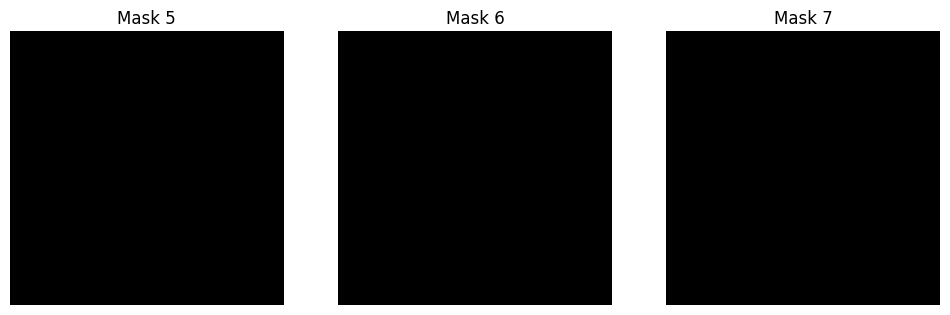

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def analyze_mask_types(add_mask_vol: np.ndarray):
    """
    Analyzes the unique mask types based on color values in the add_mask_vol.
    """
    # Get the unique values representing different mask types
    unique_mask_values = np.unique(add_mask_vol)

    # Remove zero (which could represent background or unmasked regions)
    unique_mask_values = unique_mask_values[unique_mask_values > 0]

    # Dictionary to store the mask type and its occurrence count
    mask_analysis = {}

    for value in unique_mask_values:
        # Create a binary mask for each unique value
        binary_mask = (add_mask_vol == value)

        # Count the number of pixels in the mask (non-zero regions)
        mask_size = np.sum(binary_mask)

        mask_analysis[value] = {
            'mask_size': mask_size,
            'percentage_of_total': (mask_size / add_mask_vol.size) * 100
        }

    # Print the analysis result
    for value, analysis in mask_analysis.items():
        print(f"Mask Type (Color Value {value}):")
        print(f"  Size: {analysis['mask_size']} pixels")
        print(f"  Percentage of Total Volume: {analysis['percentage_of_total']:.2f}%")
        print("-" * 50)

    # Optional: Visualize the mask types
    plt.figure(figsize=(12, 6))
    for idx, value in enumerate(mask_analysis.keys(), 1):
        plt.subplot(1, len(mask_analysis), idx)
        plt.imshow(add_mask_vol[0] == value, cmap='gray')  # Visualize the first slice of the mask
        plt.title(f"Mask {value}")
        plt.axis('off')

    plt.show()

    return mask_analysis

# Example usage (assuming `add_mask_vol` is already loaded from `load_volumes`):
raw_vol, seg_vol, add_mask_vol = load_volumes(
    bbox_name='bbox1',  # Example bbox_name
    raw_base_dir='raw',
    seg_base_dir='seg',
    add_mask_base_dir=''
)

if add_mask_vol is not None:
    mask_analysis = analyze_mask_types(add_mask_vol)
else:
    print("No additional mask volume found.")


# Data Loader Options

 This is a structured overview of the available arguments for the synapse dataset data loader.

## Arguments

### `--raw_base_dir` (Required)
- **Description**: Directory containing the raw data files (e.g., `.tif` slices).
- **Type**: `str`
- **Default**: `'raw'`
- **Example**:
    ```
    --raw_base_dir /path/to/raw/data
    ```

### `--seg_base_dir` (Required)
- **Description**: Directory containing the segmentation data files (e.g., `.tif` slices).
- **Type**: `str`
- **Default**: `'seg'`
- **Example**:
    ```
    --seg_base_dir /path/to/segmentation/data
    ```

### `--add_mask_base_dir` (Optional)
- **Description**: Directory containing additional mask files (e.g., `.tif` slices).
- **Type**: `str`
- **Default**: `''` (empty string, optional)
- **Example**:
    ```
    --add_mask_base_dir /path/to/additional/masks
    ```

### `--bbox_name` (Required)
- **Description**: List of bounding box names to process. Each bounding box corresponds to a set of data (raw, segmentation, and mask files).
- **Type**: `list[str]`
- **Default**: `['bbox1']`
- **Example**:
    ```
    --bbox_name bbox1 bbox2 bbox3
    ```

### `--excel_file` (Required)
- **Description**: Path to the directory containing Excel files with synapse information. The data from these Excel files will be used for synapse annotations.
- **Type**: `str`
- **Default**: `''` (empty string, required path to a directory)
- **Example**:
    ```
    --excel_file /path/to/excel/files
    ```

### `--csv_output_dir` (Optional)
- **Description**: Directory to save CSV outputs, such as processed data summaries.
- **Type**: `str`
- **Default**: `'csv_outputs'`
- **Example**:
    ```
    --csv_output_dir /path/to/csv/outputs
    ```

### `--size` (Optional)
- **Description**: Target size for the frames. This will resize the frames to this size before processing.
- **Type**: `tuple[int, int]`
- **Default**: `(80, 80)`
- **Example**:
    ```
    --size 128 128
    ```

### `--subvol_size` (Optional)
- **Description**: Subvolume size for extracting regions from the full volume. This size determines the 3D crop of the data.
- **Type**: `int`
- **Default**: `80`
- **Example**:
    ```
    --subvol_size 128
    ```

### `--num_frames` (Optional)
- **Description**: Number of frames to extract from the data.
- **Type**: `int`
- **Default**: `80`
- **Example**:
    ```
    --num_frames 16
    ```

### `--save_gifs_dir` (Optional)
- **Description**: Directory to save generated GIFs for each segmentation type.
- **Type**: `str`
- **Default**: `'gifs'`
- **Example**:
    ```
    --save_gifs_dir /path/to/save/gifs
    ```

### `--alpha` (Optional)
- **Description**: Alpha blending factor for combining raw image and mask. This controls how much the unmasked areas are blended with a black overlay.
- **Type**: `float`
- **Default**: `0.5`
- **Example**:
    ```
    --alpha 0.7
    ```

### `--segmentation_type` (Required)
- **Description**: Type of segmentation overlay to apply to the raw data. This option defines which mask type is used for overlaying the raw data.
- **Type**: `int`
- **Choices**:
    - `0 = Raw image` – No overlay, raw image only.
    - `1 = Raw + Side1` – Raw image overlaid with Side1.
    - `2 = Raw + Side2` – Raw image overlaid with Side2.
    - `3 = Raw + Side1 + Side2` – Raw image overlaid with both Side1 and Side2.
    - `4 = Raw + Vesicles` – Raw image overlaid with vesicle regions.
    - `5 = Raw + Side1 + Side2 + Vesicles` – Raw image overlaid with Side1, Side2, and vesicles.
    - `6 = Density` – Density regions only.
    - `7 = Cleft` – Cleft regions only.
    - `8 = Mitochondria` – Mitochondria regions only.
    - `9 = Cleft + Density` – Cleft + Density regions combined.
- **Default**: `6`
- **Example**:
    ```
    --segmentation_type 3
    ```

## Example Usage

Below is an example of how to use the data loader script with specified options:

```bash
python data_loader.py \
    --raw_base_dir /path/to/raw/data \
    --seg_base_dir /path/to/segmentation/data \
    --add_mask_base_dir /path/to/additional/masks \
    --bbox_name bbox1 bbox2 \
    --excel_file /path/to/excel/files \
    --csv_output_dir /path/to/csv/outputs \
    --save_gifs_dir /path/to/save/gifs \
    --segmentation_type 2 \
    --alpha 0.5


In [ ]:
import os
import glob
import io
import argparse
import multiprocessing
from typing import List, Tuple
import imageio
import numpy as np
import pandas as pd
import imageio.v3 as iio
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms
class Synapse3DProcessor:
    def __init__(self, size=(80, 80), mean=(0.485,),  # Use a single channel for grayscale
                 std=(0.229,)):
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(size),
            transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std),
        ])

    def __call__(self, frames, return_tensors=None):
        processed_frames = [self.transform(frame) for frame in frames]
        pixel_values = torch.stack(processed_frames)
        if return_tensors == "pt":
            return {"pixel_values": pixel_values}
        else:
            return pixel_values


def load_volumes(bbox_name: str, raw_base_dir: str, seg_base_dir: str, add_mask_base_dir: str) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    raw_dir = os.path.join(raw_base_dir, bbox_name)
    seg_dir = os.path.join(seg_base_dir, bbox_name)

    if bbox_name.startswith("bbox"):
        bbox_num = bbox_name.replace("bbox", "")
        add_mask_dir = os.path.join(add_mask_base_dir, f"bbox_{bbox_num}")
    else:
        add_mask_dir = os.path.join(add_mask_base_dir, bbox_name)

    raw_tif_files = sorted(glob.glob(os.path.join(raw_dir, 'slice_*.tif')))
    seg_tif_files = sorted(glob.glob(os.path.join(seg_dir, 'slice_*.tif')))
    add_mask_tif_files = sorted(glob.glob(os.path.join(add_mask_dir, 'slice_*.tif')))

    if not (len(raw_tif_files) == len(seg_tif_files) == len(add_mask_tif_files)):
        return None, None, None

    try:
        raw_vol = np.stack([iio.imread(f) for f in raw_tif_files], axis=0)
        seg_vol = np.stack([iio.imread(f).astype(np.uint32) for f in seg_tif_files], axis=0)
        add_mask_vol = np.stack([iio.imread(f).astype(np.uint32) for f in add_mask_tif_files], axis=0)
        return raw_vol, seg_vol, add_mask_vol
    except Exception as e:
        return None, None, None

class SynapseDataset(Dataset):
    def __init__(self, vol_data_dict: dict, synapse_df: pd.DataFrame, processor,
                 segmentation_type: int, subvol_size: int = 80, num_frames: int = 16,
                 alpha: float = 0.3):
        self.vol_data_dict = vol_data_dict
        self.synapse_df = synapse_df.reset_index(drop=True)
        self.processor = processor
        self.segmentation_type = segmentation_type
        self.subvol_size = subvol_size
        self.num_frames = num_frames
        self.alpha = alpha

    def __len__(self):
        return len(self.synapse_df)

    def __getitem__(self, idx):
        syn_info = self.synapse_df.iloc[idx]
        bbox_name = syn_info['bbox_name']
        raw_vol, seg_vol, add_mask_vol = self.vol_data_dict.get(bbox_name, (None, None, None))

        if raw_vol is None:
            return torch.zeros((self.num_frames, 3, self.subvol_size, self.subvol_size), dtype=torch.float32), syn_info, bbox_name

        central_coord = (int(syn_info['central_coord_1']), int(syn_info['central_coord_2']), int(syn_info['central_coord_3']))
        side1_coord = (int(syn_info['side_1_coord_1']), int(syn_info['side_1_coord_2']), int(syn_info['side_1_coord_3']))
        side2_coord = (int(syn_info['side_2_coord_1']), int(syn_info['side_2_coord_2']), int(syn_info['side_2_coord_3']))

        overlaid_cube = create_segmented_cube(
            raw_vol=raw_vol,
            seg_vol=seg_vol,
            add_mask_vol=add_mask_vol,
            central_coord=central_coord,
            side1_coord=side1_coord,
            side2_coord=side2_coord,
            segmentation_type=self.segmentation_type,
            subvolume_size=self.subvol_size,
            alpha=self.alpha,
        )

        frames = [overlaid_cube[..., z] for z in range(overlaid_cube.shape[3])]
        if len(frames) < self.num_frames:
            frames += [frames[-1]] * (self.num_frames - len(frames))
        elif len(frames) > self.num_frames:
            indices = np.linspace(0, len(frames)-1, self.num_frames, dtype=int)
            frames = [frames[i] for i in indices]

        inputs = self.processor(frames, return_tensors="pt")
        return inputs["pixel_values"].squeeze(0).float(), syn_info, bbox_name
# ,'bbox2','bbox3','bbox4','bbox5','bbox6',
def parse_args():
    parser = argparse.ArgumentParser(description="Synapse Dataset")
    parser.add_argument('--raw_base_dir', type=str, default='raw')
    parser.add_argument('--seg_base_dir', type=str, default='seg')
    parser.add_argument('--add_mask_base_dir', type=str, default='')
    parser.add_argument('--bbox_name', type=str, default=['bbox1'], nargs='+')
    parser.add_argument('--excel_file', type=str, default='')
    parser.add_argument('--csv_output_dir', type=str, default='csv_outputs')
    parser.add_argument('--size', type=tuple, default=(80, 80))
    parser.add_argument('--subvol_size', type=int, default=80)
    parser.add_argument('--num_frames', type=int, default=80)
    parser.add_argument('--save_gifs_dir', type=str, default='gifs')
    parser.add_argument('--alpha', type=float, default=0.5)
    parser.add_argument('--segmentation_type', type=int, default=6, choices=range(0, 10),
                        help='Type of segmentation overlay:\n'
                             '0 = Raw image\n'
                             '1 = Raw + Side1\n'
                             '2 = Raw + Side2\n'
                             '3 = Raw + Side1 + Side2\n'
                             '4 = Raw + Vesicles\n'
                             '5 = Raw + Side1 + Side2 + Vesicles\n'
                             '6 = vesicle cloud\n'
                             '7 = cleft\n'
                             '8 = Mitochondria\n'
                             '9 = Cleft + Density')
    args, _ = parser.parse_known_args()
    return args

def create_segmented_cube(
    raw_vol: np.ndarray,
    seg_vol: np.ndarray,
    add_mask_vol: np.ndarray,
    central_coord: Tuple[int, int, int],
    side1_coord: Tuple[int, int, int],
    side2_coord: Tuple[int, int, int],
    segmentation_type: int,
    subvolume_size: int = 80,
    alpha: float = 0.3,
) -> np.ndarray:
    def create_segment_masks(segmentation_volume, s1_coord, s2_coord):
        x1, y1, z1 = s1_coord
        x2, y2, z2 = s2_coord
        seg_id_1 = segmentation_volume[z1, y1, x1]
        seg_id_2 = segmentation_volume[z2, y2, x2]
        # print(seg_id_2)
        mask_2 = (segmentation_volume == seg_id_2) if seg_id_2 != 0 else np.zeros_like(segmentation_volume, dtype=bool)

        mask_1 = (segmentation_volume == seg_id_1) if seg_id_1 != 0 else np.zeros_like(segmentation_volume, dtype=bool)
        return mask_1, mask_2

    mask_1_full, mask_2_full = create_segment_masks(seg_vol, side1_coord, side2_coord)
    mask_3_full = (add_mask_vol > 0)

    # New segmentation type handling
    if segmentation_type == 0:
        combined_mask_full = np.ones_like(add_mask_vol, dtype=bool)  # Raw image (no masking)
    elif segmentation_type == 1:
        combined_mask_full = mask_1_full  # Raw + Side1
    elif segmentation_type == 2:
        combined_mask_full = mask_2_full  # Raw + Side2
    elif segmentation_type == 3:
        combined_mask_full = np.logical_or(mask_1_full, mask_2_full)  # Raw + Side1 + Side2
    elif segmentation_type == 4:
        combined_mask_full = ( mask_3_full)  # Raw + Vesicles
    elif segmentation_type == 5:
        combined_mask_full = np.logical_or(mask_1_full, np.logical_or(mask_2_full, mask_3_full))  # All masks
    elif segmentation_type == 6:
        combined_mask_full = (add_mask_vol == 6)  # vesicle cloud
    elif segmentation_type == 7:
        combined_mask_full = (add_mask_vol == 7)  # cleft
    elif segmentation_type == 8:
        combined_mask_full = (add_mask_vol == 5)  # Mitochondria
    elif segmentation_type == 9:
        combined_mask_full = np.logical_or(add_mask_vol == 6, add_mask_vol == 7)  # Cleft + Density

    half_size = subvolume_size // 2
    cx, cy, cz = central_coord
    x_start, x_end = max(cx - half_size, 0), min(cx + half_size, raw_vol.shape[2])
    y_start, y_end = max(cy - half_size, 0), min(cy + half_size, raw_vol.shape[1])
    z_start, z_end = max(cz - half_size, 0), min(cz + half_size, raw_vol.shape[0])
    sub_raw = raw_vol[z_start:z_end, y_start:y_end, x_start:x_end]
    sub_combined_mask = combined_mask_full[z_start:z_end, y_start:y_end, x_start:x_end]
    pad_z = subvolume_size - sub_raw.shape[0]
    pad_y = subvolume_size - sub_raw.shape[1]
    pad_x = subvolume_size - sub_raw.shape[2]
    if pad_z > 0 or pad_y > 0 or pad_x > 0:
        sub_raw = np.pad(sub_raw, ((0, pad_z), (0, pad_y), (0, pad_x)), mode='constant', constant_values=0)
        sub_combined_mask = np.pad(sub_combined_mask, ((0, pad_z), (0, pad_y), (0, pad_x)), mode='constant', constant_values=False)
    sub_raw = sub_raw[:subvolume_size, :subvolume_size, :subvolume_size]
    sub_combined_mask = sub_combined_mask[:subvolume_size, :subvolume_size, :subvolume_size]
    overlaid_cube = np.zeros((subvolume_size, subvolume_size, 3, subvolume_size), dtype=np.uint8)
    for z in range(subvolume_size):
        raw_slice = sub_raw[z].astype(np.float32)
        mn, mx = raw_slice.min(), raw_slice.max()
        if mx > mn:
            raw_slice = (raw_slice - mn) / (mx - mn)
        else:
            raw_slice = raw_slice - mn
        raw_rgb = np.stack([raw_slice] * 3, axis=-1)
        # Create 2D mask for unmasked regions
        mask_factor = sub_combined_mask[z]  # This is now 2D
        # Calculate average color of unmasked regions
        unmasked_pixels = raw_slice[~mask_factor]  # Get unmasked pixel values
        if len(unmasked_pixels) > 0:
            avg_color = unmasked_pixels.mean()
        else:
            avg_color = 0  # In case there are no unmasked pixels
        # Blend: apply transparency control (alpha_black)
        raw_rgb = raw_rgb * mask_factor[:, :, np.newaxis] + (1 - mask_factor[:, :, np.newaxis]) * (alpha * avg_color + (1 - alpha) * raw_rgb)
        overlaid_image = (np.clip(raw_rgb, 0, 1) * 255).astype(np.uint8)
        overlaid_cube[:, :, :, z] = overlaid_image
    return overlaid_cube


def main(args):
    processor = Synapse3DProcessor(size=(80, 80))
    vol_data_dict = {}

    for bbox_name in args.bbox_name:
        raw_vol, seg_vol, add_mask_vol = load_volumes(
            bbox_name=bbox_name,
            raw_base_dir=args.raw_base_dir,
            seg_base_dir=args.seg_base_dir,
            add_mask_base_dir=args.add_mask_base_dir
        )
        if raw_vol is not None:
            vol_data_dict[bbox_name] = (raw_vol, seg_vol, add_mask_vol)

    synapse_dfs = []
    for bbox_name in args.bbox_name:
        excel_path = os.path.join(args.excel_file, f"{bbox_name}.xlsx")
        if os.path.exists(excel_path):
            df = pd.read_excel(excel_path)
            df['bbox_name'] = bbox_name
            synapse_dfs.append(df)

    syn_df = pd.concat(synapse_dfs, ignore_index=True)
    dataset = SynapseDataset(
        vol_data_dict=vol_data_dict,
        synapse_df=syn_df,
        processor=processor,
        segmentation_type=args.segmentation_type,
        subvol_size=args.subvol_size,
        num_frames=args.num_frames,
        alpha=args.alpha,
    )

    cubes = []
    syn_info_list = []
    for idx in range(len(dataset)):
        pixel_values, syn_info, _ = dataset[idx]
        cubes.append(pixel_values)
        syn_info_list.append(syn_info)

    print(f"Processed {len(cubes)} cubes successfully.")
    return cubes, pd.DataFrame(syn_info_list)

# if __name__ == "__main__":
args = parse_args()
args.segmentation_type=2
args.bbox_name=['bbox1']
cubes, sys_inf = main(args)
print(f"Final output: {len(cubes)} cubes")

# Extract the data tensor (cube) from the tuple returned by dataset[0]
cube = cubes[0]

mean = torch.tensor([0.485]).view(1, 1, 1, 1)
std = torch.tensor([0.229]).view(1, 1, 1, 1)

denormalized_cube = cube * std + mean
denormalized_cube = torch.clamp(denormalized_cube, 0, 1)

# Convert to RGB if needed
frames = denormalized_cube.squeeze(1).numpy()
frames = (frames * 255).astype(np.uint8)

# Stack to create RGB
frames = np.stack([frames, frames, frames], axis=-1)

Gif_Name = f"VGG_Gif_segmentation_type_{args.segmentation_type}_alpha_{args.alpha}"
output_gif_path = os.path.join("", f"{Gif_Name}.gif")
# Save the frames as a gif using imageio
imageio.mimsave(output_gif_path, frames, fps=10)

[False  True]
[False  True]
[False  True]
[False  True]
[False  True]
[False  True]
[False  True]
[False  True]
[False  True]
[False  True]
[False  True]
[False  True]
[False  True]
[False  True]
[False  True]
[False  True]
[False  True]
[False  True]
[False  True]
[False  True]
[False  True]
[False  True]
[False  True]
[False  True]
[False  True]
[False  True]
[False  True]
[False  True]
[False  True]
[False  True]
[False  True]
[False  True]
[False  True]
[False  True]
[False  True]
[False  True]
[False  True]
[False  True]
[False  True]
[False  True]
[False  True]
[False  True]
[False  True]
[False  True]
[False  True]
[False  True]
[False  True]
[False  True]
[False  True]
[False  True]
[False  True]
[False  True]
[False  True]
[False  True]
[False  True]
[False  True]
[False  True]


# Final Test for Dataloader

In [31]:
!mkdir gifs

In [32]:
def generate_gifs_for_all_segmentations(args):
    # Loop through all segmentation types (0-9)
    for segmentation_type in range(10):
        print(f"Generating GIF for segmentation type {segmentation_type}...")

        # Update the segmentation_type in the arguments
        args.segmentation_type = segmentation_type

        # Run the main function to process the dataset for the current segmentation type
        cubes, sys_inf = main(args)

        # Extract the first cube (sample) for GIF generation
        cube = cubes[0]

        # Denormalize the cube (if necessary)
        mean = torch.tensor([0.485]).view(1, 1, 1, 1)
        std = torch.tensor([0.229]).view(1, 1, 1, 1)
        denormalized_cube = cube * std + mean
        denormalized_cube = torch.clamp(denormalized_cube, 0, 1)

        # Convert to RGB if needed
        frames = denormalized_cube.squeeze(1).numpy()
        frames = (frames * 255).astype(np.uint8)

        # Stack to create RGB frames (if necessary)
        frames_rgb = np.stack([frames, frames, frames], axis=-1)

        # Generate the output GIF name
        Gif_Name = f"VGG_Gif_segmentation_type_{segmentation_type}_alpha_{args.alpha}"
        output_gif_path = os.path.join(args.save_gifs_dir, f"{Gif_Name}.gif")

        # Save the frames as a GIF using imageio
        imageio.mimsave(output_gif_path, frames_rgb, fps=10)

        print(f"GIF for segmentation type {segmentation_type} saved to {output_gif_path}")

# Run the function to generate GIFs for all segmentation types
args = parse_args()
args.save_gifs_dir = 'gifs'  # Make sure the save directory exists
generate_gifs_for_all_segmentations(args)


Generating GIF for segmentation type 0...
Processed 58 cubes successfully.
GIF for segmentation type 0 saved to gifs/VGG_Gif_segmentation_type_0_alpha_0.5.gif
Generating GIF for segmentation type 1...
Processed 58 cubes successfully.
GIF for segmentation type 1 saved to gifs/VGG_Gif_segmentation_type_1_alpha_0.5.gif
Generating GIF for segmentation type 2...
Processed 58 cubes successfully.
GIF for segmentation type 2 saved to gifs/VGG_Gif_segmentation_type_2_alpha_0.5.gif
Generating GIF for segmentation type 3...
Processed 58 cubes successfully.
GIF for segmentation type 3 saved to gifs/VGG_Gif_segmentation_type_3_alpha_0.5.gif
Generating GIF for segmentation type 4...
Processed 58 cubes successfully.
GIF for segmentation type 4 saved to gifs/VGG_Gif_segmentation_type_4_alpha_0.5.gif
Generating GIF for segmentation type 5...
Processed 58 cubes successfully.
GIF for segmentation type 5 saved to gifs/VGG_Gif_segmentation_type_5_alpha_0.5.gif
Generating GIF for segmentation type 6...
Proc

In [33]:
import shutil

# Replace 'folder_name' with the name of your folder
shutil.make_archive('/content/gifs', 'zip', '/content/gifs')
from google.colab import files

# Download the zip file
files.download('/content/gifs.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>